Dataset shape: (530443, 418)

Column names:
['id', 'name', 'status', 'bid', 'level', 'vocation', 'server', 'is_name_contains_special_character', 'axe_fighting', 'club_fighting', 'distance_fighting', 'fishing', 'fist_fighting', 'magic_level', 'shielding', 'sword_fighting', 'mounts', 'outfits', 'gold', 'achievement_points', 'is_transfer_available', 'available_charm_points', 'spent_charm_points', 'charm_expansion', 'hunting_task_points', 'permanent_prey_task_slot', 'permanent_hunt_task_slot', 'prey_wildcards', 'hirelings', 'hirelings_jobs', 'hirelings_outfits', 'auction_start_date_iso', 'auction_end_date_iso', 'imbuements', 'charms', 'server_location', 'pvp_type', 'battleye', 'server_experimental', 'imbuements_Powerful_Bash', 'imbuements_Powerful_Blockade', 'imbuements_Powerful_Chop', 'imbuements_Powerful_Cloud_Fabric', 'imbuements_Powerful_Demon_Presence', 'imbuements_Powerful_Dragon_Hide', 'imbuements_Powerful_Electrify', 'imbuements_Powerful_Epiphany', 'imbuements_Powerful_Featherweigh

/tmp/ipykernel_9773/3583879595.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  level_stats = df.groupby('level_range').agg({


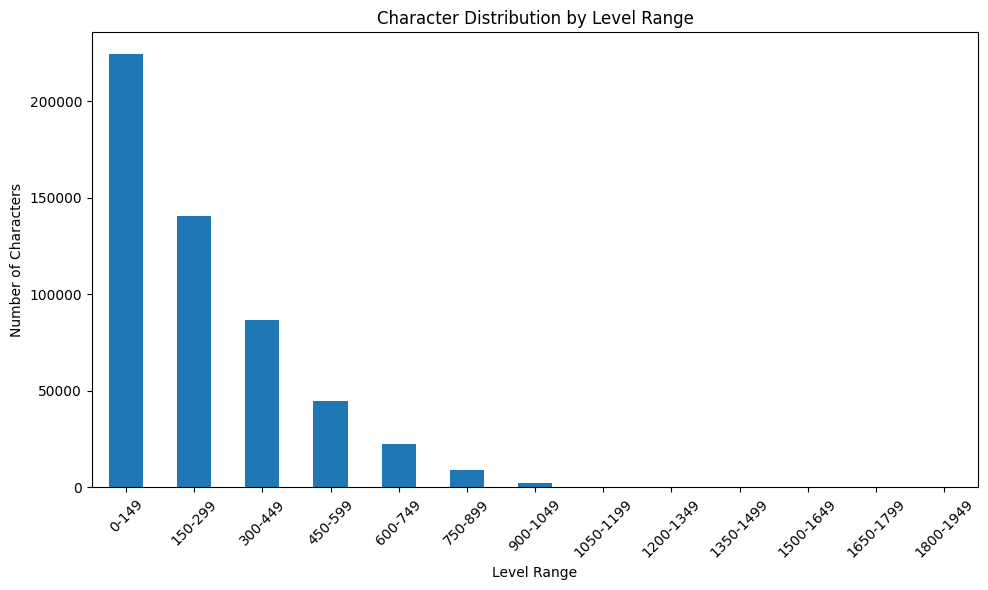

In [12]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file from the data folder
df = pd.read_csv('../data/characters_processed.csv', na_filter=False)  # Replace 'your_file.csv' with actual filename

bid_99_percentile = np.percentile(df['bid'], 99)
df = df[df['bid'] <= bid_99_percentile]

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Show information by character level range (assuming there's a level column)
if 'level' in df.columns.str.lower():
    level_col = [col for col in df.columns if 'level' in col.lower()][0]
    
    # Create level ranges
    df['level_range'] = pd.cut(df[level_col], 
                              bins=list(range(0, 2001, 150)), 
                              labels=[f'{i}-{i+149}' for i in range(0, 1850, 150)])
    # Show statistics by level range
    print(f"\nCharacter distribution by level range:")
    level_stats = df.groupby('level_range').agg({
        level_col: ['count', 'mean', 'min', 'max']
    }).round(2)
    print(level_stats)
    
    # Plot level distribution
    plt.figure(figsize=(10, 6))
    df['level_range'].value_counts().sort_index().plot(kind='bar') 
    plt.title('Character Distribution by Level Range')
    plt.xlabel('Level Range')
    plt.ylabel('Number of Characters')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo level column found. Available columns:")
    print(df.columns.tolist())

In [16]:
df['server_location'] = df['server_location'].replace('NA', 'NAM')
df['auction_start_date'] = pd.to_datetime(df['auction_start_date_iso'])
df['auction_end_date'] = pd.to_datetime(df['auction_end_date_iso'])
df['auction_duration_hours'] = (df['auction_end_date'] - df['auction_start_date']).dt.total_seconds() / 3600
first_auction_date = df['auction_start_date'].min()
df['days_since_first_auction'] = (df['auction_start_date'] - first_auction_date).dt.days
server_first_auction = df.groupby('server')['auction_start_date'].min().rename('server_first_auction')
df = df.merge(server_first_auction.to_frame(), left_on='server', right_index=True)
df['days_since_server_first_auction'] = (df['auction_start_date'] - df['server_first_auction']).dt.days
df.drop('server_first_auction', axis=1, inplace=True)
df['auction_hour'] = df['auction_start_date'].dt.hour
df['auction_day_of_week'] = df['auction_start_date'].dt.dayofweek


In [13]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Evaluate the model
def evaluate_model(y_true, y_pred, dataset_name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)          # scale-free
    r2   = r2_score(y_true, y_pred)
    ev   = explained_variance_score(y_true, y_pred)

    # Two handy relative error measures
    nrmse = rmse / (y_true.max() - y_true.min())                   # 0–1 scale
    srmse = rmse / np.std(y_true, ddof=0)                          # vs target σ

    metrics = {
        "MSE":  mse,
        "RMSE": rmse,
        "NRMSE_range": nrmse,
        "SRMSE_std":  srmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2,
        "Explained_Variance": ev,
    }

    print(f"\n{dataset_name} metrics")
    for k, v in metrics.items():
        print(f"{k:18s}: {v:.4f}" if k != "MSE" else f"{k:18s}: {v:,.2f}")

    return metrics

In [18]:
"""
X = df.drop(['id', 'name', 'status', 'bid', 'auction_start_date_iso', 'auction_end_date_iso', 
              'auction_start_date', 'auction_end_date'], axis=1)
y = df['bid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = (numerical_cols + 
                preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())

model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    device="cuda",
    early_stopping_rounds=30,
)

model.fit(X_train_processed, y_train, 
          eval_set=[(X_train_processed, y_train), (X_test_processed, y_test)],
          verbose=False)

y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)


# Evaluate on training data
evaluate_model(y_train, y_train_pred, "Training")

# Evaluate on testing data
evaluate_model(y_test, y_test_pred, "Testing")


"""

# Get unique level ranges for training separate models
level_ranges = df['level_range'].cat.categories

# Dictionary to store models and results for each level range
level_models = {}
level_results = {}

for level_range in level_ranges:
    print(f"\n{'='*60}")
    print(f"Training model for level range: {level_range}")
    print(f"{'='*60}")
    
    # Filter data for current level range
    df_level = df[df['level_range'] == level_range].copy()
    
    # Skip if not enough data
    if len(df_level) < 100:
        print(f"Skipping {level_range} - insufficient data ({len(df_level)} samples)")
        continue
    
    print(f"Training samples: {len(df_level)}")
    
    # Prepare features and target
    X_level = df_level.drop(['id', 'name', 'status', 'bid', 'auction_start_date_iso', 'auction_end_date_iso', 
                            'auction_start_date', 'auction_end_date'], axis=1)
    y_level = df_level['bid']
    
    # Train-test split
    X_train_level, X_test_level, y_train_level, y_test_level = train_test_split(
        X_level, y_level, test_size=0.2, random_state=42)
    
    # Identify categorical and numerical columns
    categorical_cols_level = X_level.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
    numerical_cols_level = X_level.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
    
    # Preprocessing
    preprocessor_level = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols_level),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_level)
        ])
    
    X_train_processed_level = preprocessor_level.fit_transform(X_train_level)
    X_test_processed_level = preprocessor_level.transform(X_test_level)
    
    # Train XGBoost model
    model_level = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.1,
        max_depth=8,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        objective='reg:squarederror',
        tree_method='hist',
        device="cuda",
        early_stopping_rounds=30,
    )
    
    model_level.fit(X_train_processed_level, y_train_level, 
                   eval_set=[(X_train_processed_level, y_train_level), (X_test_processed_level, y_test_level)],
                   verbose=False)
    
    # Make predictions
    y_train_pred_level = model_level.predict(X_train_processed_level)
    y_test_pred_level = model_level.predict(X_test_processed_level)
    
    # Evaluate model
    train_metrics = evaluate_model(y_train_level, y_train_pred_level, f"Training - {level_range}")
    test_metrics = evaluate_model(y_test_level, y_test_pred_level, f"Testing - {level_range}")
    
    # Store results
    level_models[level_range] = {
        'model': model_level,
        'preprocessor': preprocessor_level,
        'feature_names': numerical_cols_level + preprocessor_level.named_transformers_['cat'].get_feature_names_out(categorical_cols_level).tolist()
    }
    
    level_results[level_range] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'train_size': len(y_train_level),
        'test_size': len(y_test_level)
    }

print(f"\n{'='*60}")
print("SUMMARY OF ALL LEVEL RANGE MODELS")
print(f"{'='*60}")

# Summary table
summary_data = []
for level_range in level_results.keys():
    summary_data.append({
        'Level Range': level_range,
        'Train Size': level_results[level_range]['train_size'],
        'Test Size': level_results[level_range]['test_size'],
        'Train R2': level_results[level_range]['train_metrics']['R2'],
        'Test R2': level_results[level_range]['test_metrics']['R2'],
        'Test RMSE': level_results[level_range]['test_metrics']['RMSE'],
        'Test MAPE': level_results[level_range]['test_metrics']['MAPE']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


Training model for level range: 0-149
Training samples: 224443

Training - 0-149 metrics
MSE               : 90,966.92
RMSE              : 301.6072
NRMSE_range       : 0.0060
SRMSE_std         : 0.2147
MAE               : 136.9072
MAPE              : 0.6714
R2                : 0.9539
Explained_Variance: 0.9539

Testing - 0-149 metrics
MSE               : 898,951.81
RMSE              : 948.1307
NRMSE_range       : 0.0190
SRMSE_std         : 0.6406
MAE               : 203.2679
MAPE              : 0.8857
R2                : 0.5896
Explained_Variance: 0.5897

Training model for level range: 150-299
Training samples: 140738

Training - 150-299 metrics
MSE               : 114,625.10
RMSE              : 338.5633
NRMSE_range       : 0.0068
SRMSE_std         : 0.2422
MAE               : 236.3031
MAPE              : 0.2745
R2                : 0.9414
Explained_Variance: 0.9414

Testing - 150-299 metrics
MSE               : 405,372.41
RMSE              : 636.6886
NRMSE_range       : 0.0159
SRMSE_

/tmp/ipykernel_9773/2210429699.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(bid_data_by_range, labels=labels)


<Figure size 1400x800 with 0 Axes>

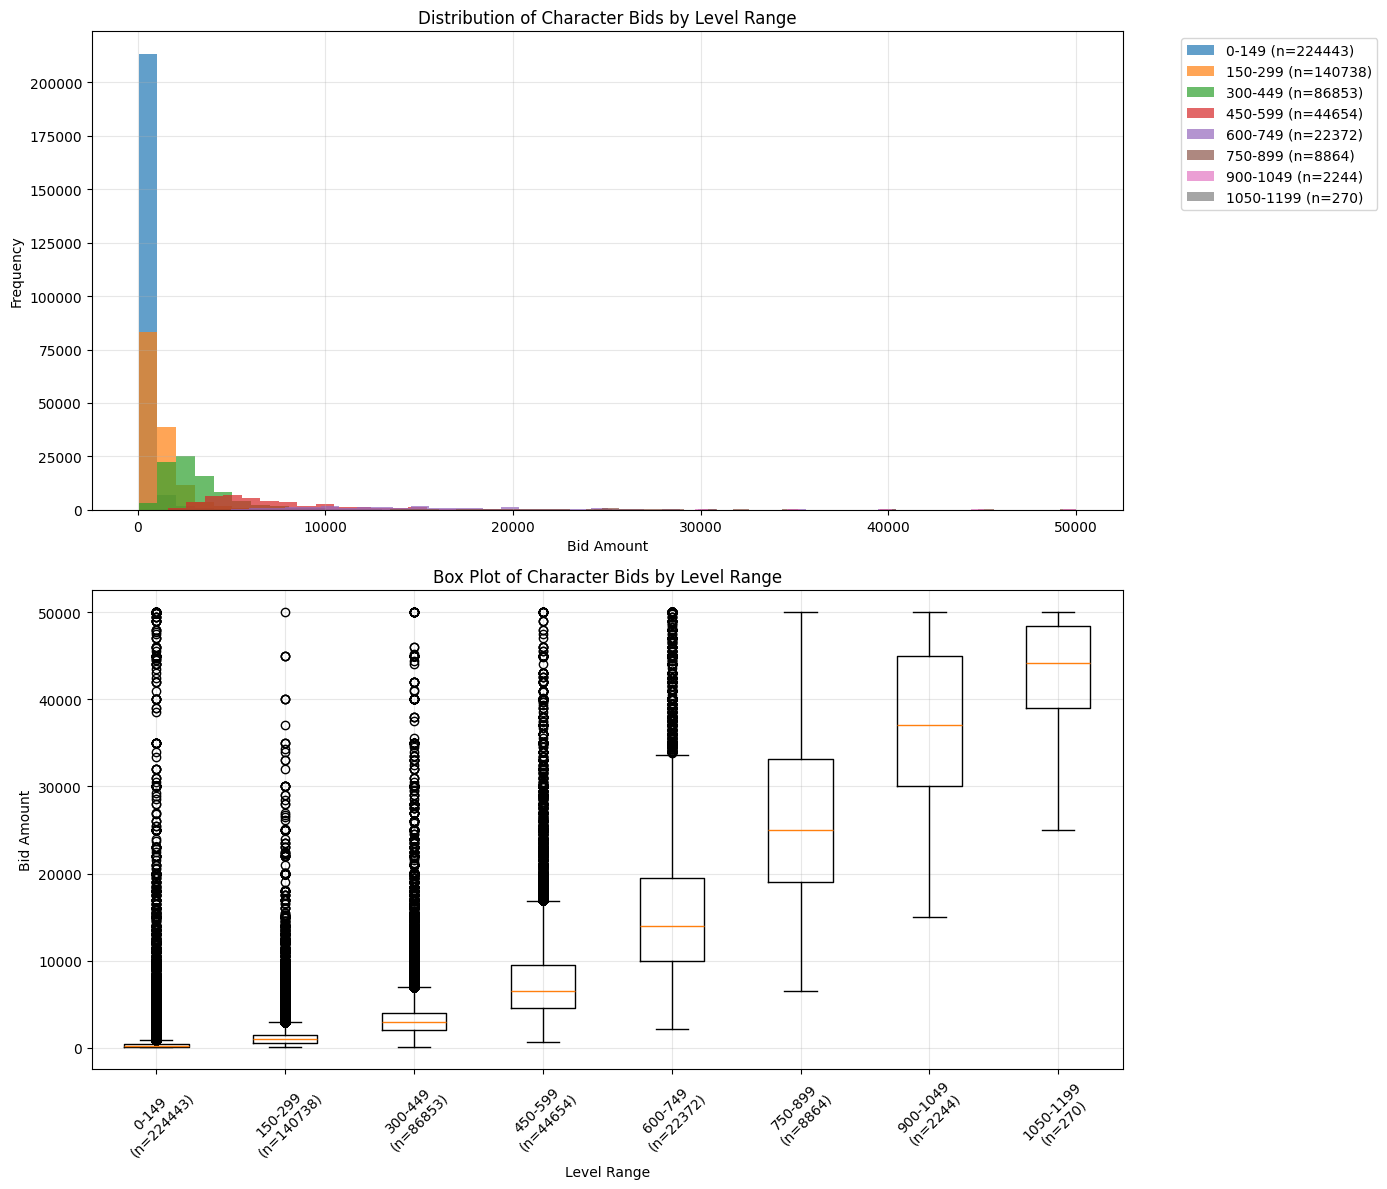


Bid Statistics by Level Range:
Level Range  Count     Mean  Median     Std   Min   Max  25th %ile  75th %ile
      0-149 224443   414.38   200.0 1420.08    57 50000     100.00     400.00
    150-299 140738  1272.15   951.0 1395.07    57 50000     531.00    1501.00
    300-449  86853  3526.74  2991.0 2901.17    57 50000    2000.00    4000.00
    450-599  44654  7894.86  6500.0 5223.63   601 50000    4553.00    9500.00
    600-749  22372 15758.47 14000.0 8455.46  2101 50000   10000.00   19500.00
    750-899   8864 26760.51 25000.0 9724.87  6501 50000   19003.75   33161.75
   900-1049   2244 36875.46 37000.0 8575.42 15003 50000   30000.00   45000.00
  1050-1199    270 42772.03 44125.5 5976.44 25000 50000   39000.00   48451.00


In [20]:
# Plot distribution of character bids per level range
plt.figure(figsize=(14, 8))

# Create subplot for better visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Histogram of bids by level range
for i, level_range in enumerate(level_ranges):
    if level_range in level_results:
        level_data = df[df['level_range'] == level_range]['bid']
        ax1.hist(level_data, bins=50, alpha=0.7, label=f'{level_range} (n={len(level_data)})')

ax1.set_xlabel('Bid Amount')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Character Bids by Level Range')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot of bids by level range
bid_data_by_range = []
labels = []
for level_range in level_ranges:
    if level_range in level_results:
        level_data = df[df['level_range'] == level_range]['bid']
        if len(level_data) > 0:
            bid_data_by_range.append(level_data)
            labels.append(f'{level_range}\n(n={len(level_data)})')

ax2.boxplot(bid_data_by_range, labels=labels)
ax2.set_xlabel('Level Range')
ax2.set_ylabel('Bid Amount')
ax2.set_title('Box Plot of Character Bids by Level Range')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\nBid Statistics by Level Range:")
bid_stats = []
for level_range in level_ranges:
    if level_range in level_results:
        level_data = df[df['level_range'] == level_range]['bid']
        if len(level_data) > 0:
            bid_stats.append({
                'Level Range': level_range,
                'Count': len(level_data),
                'Mean': level_data.mean(),
                'Median': level_data.median(),
                'Std': level_data.std(),
                'Min': level_data.min(),
                'Max': level_data.max(),
                '25th %ile': level_data.quantile(0.25),
                '75th %ile': level_data.quantile(0.75)
            })

bid_stats_df = pd.DataFrame(bid_stats)
print(bid_stats_df.round(2).to_string(index=False))